In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
%matplotlib inline  
pd.options.display.max_columns = None
import warnings
warnings.filterwarnings('ignore')
import pickle

#### import data

In [31]:
df = pd.read_pickle('project_donation_optimized.pkl')

In [32]:
## get US dataset by mapping the states
xl = pd.ExcelFile('state_long_lat.xlsx')
lon_lat_map = xl.parse('state_long_lat')
us_states = lon_lat_map['State_Short']
df_us = df[(df['donor_state'].notnull()) & (df['donor_state'].isin(us_states))]

In [33]:
df_m = df_us[['_donor_acctid', 'donation_total', 'primary_focus_area']]
df_m.head()

,_donor_acctid,donation_total,primary_focus_area
1,ba7d4afdfc182c4c5fde1d57980697bc,255.449997,Literacy & Language
2,9b29654e7ea1241e6fa1ec4805b7429e,195.449997,Literacy & Language
3,b8f54362e335b81171ebbe36c657ea4b,50.000000,Literacy & Language
4,c91489d7b6b89943a28555e6add72509,75.000000,Literacy & Language
5,c91489d7b6b89943a28555e6add72509,5.960000,Literacy & Language


#### get donation summary for each donor

In [34]:
## get dummy variables for primary focus area
dummies = pd.get_dummies(data=df_m, columns=['primary_focus_area']).groupby(['_donor_acctid']).sum()
## get donation summary stats
donation_summary = df_m.groupby(['_donor_acctid'])['donation_total'].agg(['count', 'min', 'max', 'mean'])

In [35]:
## get all features together for each donor
donation_per_user = pd.merge(donation_summary, dummies, left_index=True, right_index=True)
teacher_acct = df_us[['_donor_acctid', 'is_teacher_acct']].drop_duplicates().set_index('_donor_acctid')
donation_per_user = pd.merge(teacher_acct, donation_per_user, left_index=True, right_index=True)
donation_per_user.columns = ['is_teacher_acct', 'donation_count', 'min_donation', 'max_donation', 'mean_donation'
                             , 'total_donation', 'applied_learning', 'health_sports', 'history_civics', 'literacy_language'
                             , 'math_science', 'music_arts', 'special_needs']
donation_per_user.head()

,is_teacher_acct,donation_count,min_donation,max_donation,mean_donation,total_donation,applied_learning,health_sports,history_civics,literacy_language,math_science,music_arts,special_needs
_donor_acctid,,,,,,,,,,,,,
ba7d4afdfc182c4c5fde1d57980697bc,0,735,27.00,3499.929932,340.779266,250472.750000,56.0,5.0,36.0,337.0,196.0,57.0,48.0
9b29654e7ea1241e6fa1ec4805b7429e,0,72,45.00,953.179993,342.223053,24640.060547,7.0,2.0,0.0,50.0,10.0,3.0,0.0
b8f54362e335b81171ebbe36c657ea4b,0,10,2.65,50.000000,32.764999,327.649994,0.0,0.0,0.0,8.0,0.0,0.0,2.0
c91489d7b6b89943a28555e6add72509,1,8,5.96,75.000000,30.370001,242.960007,0.0,0.0,0.0,8.0,0.0,0.0,0.0
5551a5dab1369830dcc872c8e295009a,1,61,5.00,120.000000,23.924263,1459.380005,5.0,0.0,5.0,44.0,4.0,2.0,1.0


#### machine learning - KNN

features used:
* is_teacher_acct
* count, min, max, mean, sum of donations
* dummy variables for primary_focus_area

In [36]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score

In [37]:
## create the feature vectors for previous donors for KMeans Clustering
x_cols = np.matrix(donation_per_user)

In [38]:
## normalize the features
x_cols_norm = Normalizer().fit_transform(x_cols)
x_cols_norm

array([[0.00000000e+00, 2.93414536e-03, 1.07784932e-04, ...,
        7.82438764e-04, 2.27545967e-04, 1.91617656e-04],
       [0.00000000e+00, 2.91958195e-03, 1.82473872e-03, ...,
        4.05497493e-04, 1.21649248e-04, 0.00000000e+00],
       [0.00000000e+00, 3.00010834e-02, 7.95028739e-03, ...,
        0.00000000e+00, 0.00000000e+00, 6.00021668e-03],
       ...,
       [0.00000000e+00, 1.99920048e-02, 4.99800120e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.99920048e-02, 4.99800120e-01, ...,
        1.99920048e-02, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.99920048e-02, 4.99800120e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

#### find the optimal k

In [39]:
clusters = range(2, 8)
sse = []

for k in clusters:
    model = KMeans(n_clusters=k).fit(x_cols_norm)
    labels = model.fit_predict(x_cols_norm)
    sse.append(model.inertia_)

print('SSE:', sse)

SSE: [27038.63860379533, 15058.205029683822, 10896.912566192519, 8796.608817562452, 7846.163514025516, 7047.97759380161]


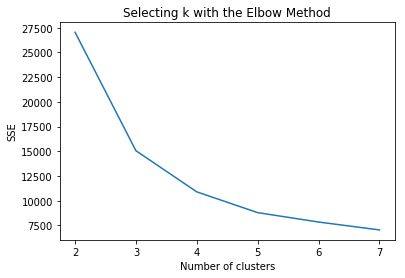

In [40]:
plt.plot(clusters, sse)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Selecting k with the Elbow Method')
plt.show()

elbow either around 3 or 5. Do both clusters. 

In [41]:
kmeans_1 = KMeans(n_clusters=3)
labels_1 = kmeans_1.fit_predict(x_cols_norm)

In [42]:
## save the model
import pickle
filename = 'model_kmeans.sav'
pickle.dump(kmeans_1, open(filename, 'wb'))

visualizing clusters using PCA

In [43]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x_cols_norm)
pca_features = pca.transform(x_cols_norm)

In [44]:
x = [item[0] for item in pca_features]
y = [item[1] for item in pca_features]
d = {"donor_id": donation_per_user.index, "cluster_id": labels_1, "x": x, "y": y}
df_pca = pd.DataFrame(d)
print(df_pca.head())

   cluster_id                          donor_id         x         y
0           2  ba7d4afdfc182c4c5fde1d57980697bc  0.823809 -0.225622
1           2  9b29654e7ea1241e6fa1ec4805b7429e  0.810489 -0.205557
2           2  b8f54362e335b81171ebbe36c657ea4b  0.731660 -0.113302
3           2  c91489d7b6b89943a28555e6add72509  0.655606  0.000276
4           2  5551a5dab1369830dcc872c8e295009a  0.796082 -0.174759


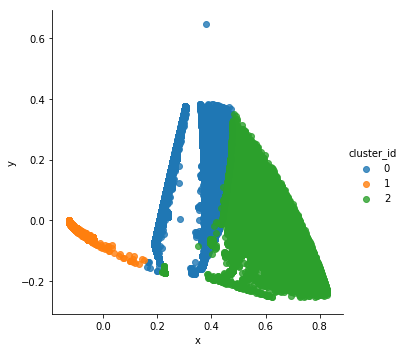

In [45]:
sns.lmplot(x="x", y="y", data=df_pca, hue="cluster_id", fit_reg=False)

#### add clusters and PCA features back to database

In [46]:
df_cluster = df_us.merge(df_pca, left_on='_donor_acctid', right_on='donor_id')
df_cluster.head()

,_donationid,_projectid,_donor_acctid,donor_city,donor_state,is_teacher_acct,donation_timestamp,donation_to_project,donation_optional_support,donation_total,payment_method,is_teacher_referred,thank_you_packet_mailed,_teacher_acctid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,school_county,teacher_prefix,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,total_donations,num_donors,eligible_double_your_impact_match,eligible_almost_home_match,funding_status,date_posted,date_completed,date_thank_you_packet_mailed,date_expiration,cluster_id,donor_id,x,y
0,53ec9a692cd770d6e4f0c6673451ff60,69bf3a609bb4673818e0eebd004ea504,ba7d4afdfc182c4c5fde1d57980697bc,NaN,CA,0,2011-03-18 01:54:04.960,217.130005,38.320000,255.449997,double_your_impact_match,0,f,b023fd4d537d99f7cf728306b5377cea,6.123300e+10,38.463570,-121.422150,Sacramento,CA,95823.0,urban,Elk Grove Unif School District,Sacramento,Mrs.,Literature & Writing,Literacy & Language,Mathematics,Math & Science,Technology,highest poverty,Grades PreK-2,434.260010,510.890015,23.0,510.899994,4,t,f,completed,2011-01-23,2011-03-18,2011-05-10,2011-06-21,2,ba7d4afdfc182c4c5fde1d57980697bc,0.823809,-0.225622
1,6d90d1176d75972053b2f122704bf353,ebbcd4dee5069e4caacbc38c99abaf0a,ba7d4afdfc182c4c5fde1d57980697bc,NaN,CA,0,2011-02-24 22:29:50.721,101.169998,17.850000,119.019997,double_your_impact_match,0,f,ee49eb8ef8963e2af126f95c6eb282f7,4.815270e+11,27.791668,-97.430534,Corpus Christi,TX,78408.0,urban,Corpus Christi Ind Sch Dist,Nueces,Ms.,Literacy,Literacy & Language,Literature & Writing,Literacy & Language,Technology,highest poverty,Grades 6-8,202.350006,238.059998,105.0,235.690002,9,t,f,completed,2011-02-20,2011-02-24,2011-05-31,2011-07-20,2,ba7d4afdfc182c4c5fde1d57980697bc,0.823809,-0.225622
2,c1ecbb81a7329d54a72a65c28c44fafb,f17ec505112e73d642faff1055c1d606,ba7d4afdfc182c4c5fde1d57980697bc,NaN,CA,0,2011-01-26 21:55:59.220,117.459999,20.730000,138.190002,double_your_impact_match,0,t,ffe0082f0a7f6d855726df72b2c7886a,4.090600e+10,33.544788,-112.099457,Phoenix,AZ,85021.0,urban,Washington Elem Sch Dist 6,Maricopa,Mrs.,Literature & Writing,Literacy & Language,Civics & Government,History & Civics,Technology,highest poverty,Grades 6-8,234.919998,276.380005,130.0,275.149994,13,t,f,completed,2011-01-25,2011-01-26,2011-04-11,2011-06-23,2,ba7d4afdfc182c4c5fde1d57980697bc,0.823809,-0.225622
3,001bd16148cbd5666988a60b957c5c83,6ee4e855b48631f825ba4617aa132ba6,ba7d4afdfc182c4c5fde1d57980697bc,NaN,CA,0,2011-03-09 14:00:34.914,455.029999,80.300003,535.330017,double_your_impact_match,0,f,b11c897eefb5d86ba4b27699d1ae9bbe,6.170400e+10,33.868649,-118.391403,Hermosa Beach,CA,90254.0,suburban,Hermosa Beach City Sch Dist,Los Angeles,Ms.,Environmental Science,Math & Science,Mathematics,Math & Science,Technology,low poverty,Grades PreK-2,910.059998,1070.660034,48.0,1070.660034,2,t,f,completed,2011-02-08,2011-03-09,2011-03-09,2011-07-06,2,ba7d4afdfc182c4c5fde1d57980697bc,0.823809,-0.225622
4,65528cf932ecdb11cba1fe37ac075288,9b01a0e84d7732577a7188408b49fe7d,ba7d4afdfc182c4c5fde1d57980697bc,NaN,CA,0,2011-02-08 08:51:33.497,213.449997,37.669998,251.119995,double_your_impact_match,0,t,29e0ff46963962adcc014689cd9dfbad,4.502310e+11,34.857063,-82.439285,Greenville,SC,29611.0,suburban,Greenville Co School District,Greenville,Mr.,Literacy,Literacy & Language,Social Sciences,History & Civics,Technology,highest poverty,Grades 3-5,426.910004,502.250000,50.0,502.070007,23,t,f,completed,2011-02-05,2011-02-08,2011-03-18,2011-07-01,2,ba7d4afdfc182c4c5fde1d57980697bc,0.823809,-0.225622


In [47]:
df_cluster.to_pickle('clustered_dataframe.pkl')